# Panorama Stitching
Problem Statement: Given N overlapped images, stitch them together to make a single image.
1. Image Features -  SIFT
2. Matching Features -  BFMatcher
3. Homography Matrix - To map a point in one image to the corresponding point in another image.
4. Warping - Process of transforming an image taken from one view point to an image taken from other view point.
5. RANSAC - An iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers.

In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
img1 = cv2.imread('dataset/2/weir_1.jpg')
img2 = cv2.imread('dataset/2/weir_2.jpg')
img3 = cv2.imread('dataset/2/weir_3.jpg')
result = cv2.imread('dataset/2/stitched_backward_warped.jpg')

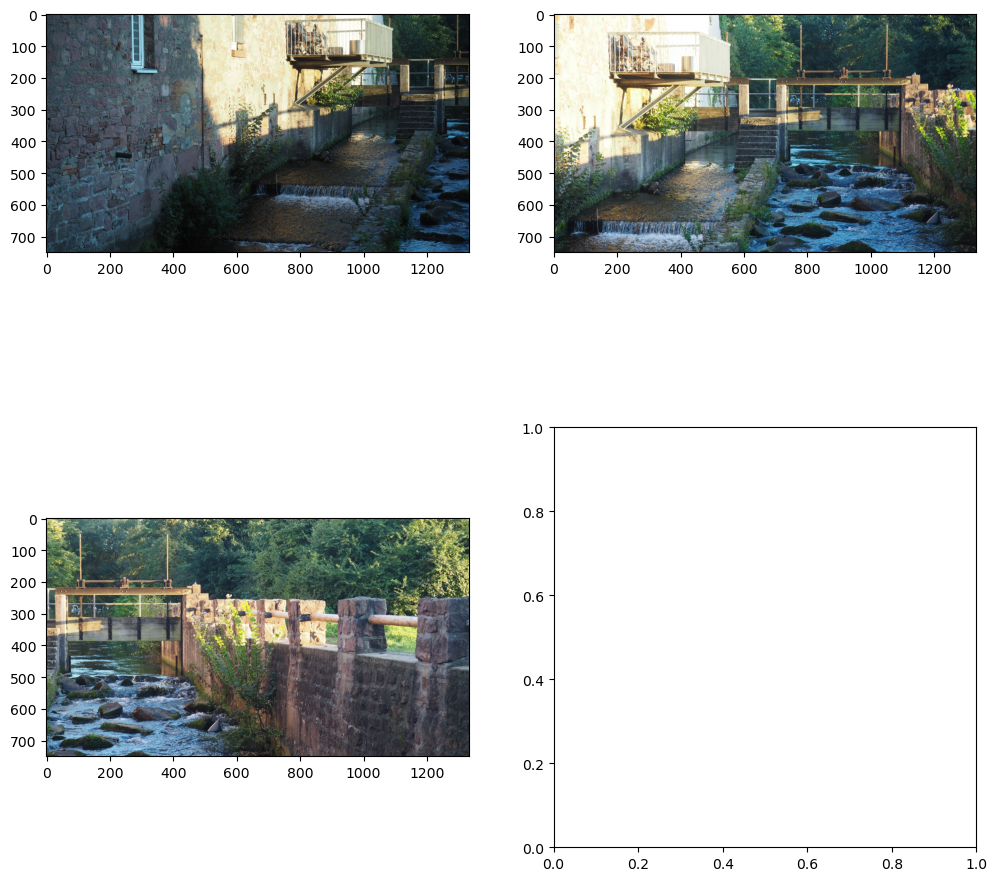

In [3]:
f, axarr = plt.subplots(2,2)
f.set_figwidth(12)
f.set_figheight(12)
axarr[0,0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axarr[0,1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axarr[1,0].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

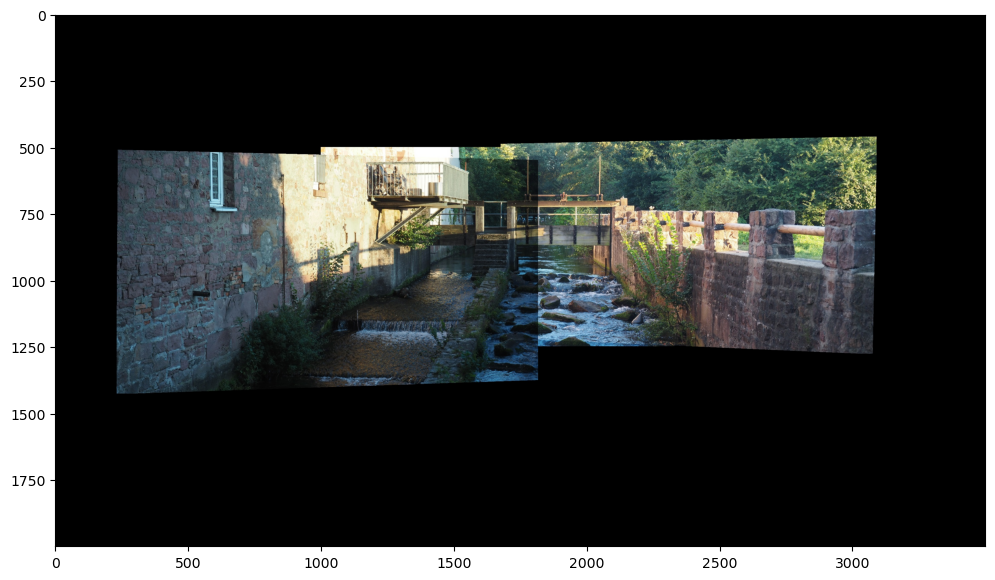

In [4]:
f, axarr = plt.subplots(1,1)
f.set_figwidth(12)
f.set_figheight(12)
axarr.imshow(cv2.cvtColor(result[:,:3500,:], cv2.COLOR_BGR2RGB))

## Extract Features 

Using [SIFT algorithm](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) to extract the features from the images. These features are later matched and the matched features are used to calculate the homography matrix.

This algorighm is scale variance agnostic which bascially means should the scale of a feature change the descriptor should not get affected by the scale change.  

In [5]:
sift = cv2.SIFT_create()
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

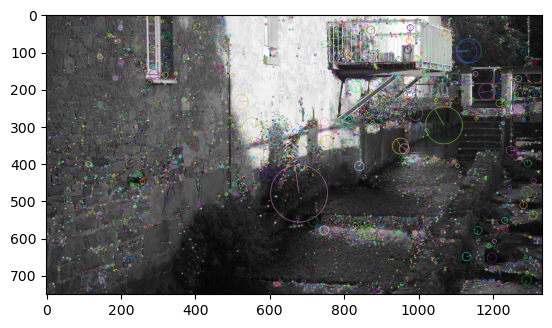

In [6]:
img=cv2.drawKeypoints(img1_gray, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## Match the features from two images

Once we have extracted the features from the two images which we want to stitch. Then we need to match the features. We'll use [Brute-Force matcher](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html) to match the keypoints.

In [7]:
NO_OF_POINTS = 20
bf = cv2.BFMatcher(cv2.NORM_L2)
# descriptors of image2 should be passed as source descriptors
matches = bf.match(descriptors2, descriptors1)
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:NO_OF_POINTS]

In [11]:
matched_image = cv2.drawMatches(img2_gray,keypoints2,img1_gray,keypoints1,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('matched_image.jpg', matched_image)

True

## Calculate the homography matrix

For planar surfaces, 3D to 2D perspective projection reduces to a 2D to 2D transformation. For more details checkout the [slides](https://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf)

Once we have the Correspondence points from last step. We use these points to calculate the homography to warp image2 to coordinate frame of image1. Check the video [here](https://www.youtube.com/watch?v=l_qjO4cM74o&t=369s) to understand homography and how to calculate it. It basically is the eigen vector corresponding to the smallest eigen value of [A.T*A], where A has dimensions 2xN rows and 9 cols, and can be constructed using the correspondence points.


In [12]:
A = np.array([])
for match in matches:
    xs,ys = keypoints2[match.queryIdx].pt
    xd,yd = keypoints1[match.trainIdx].pt
    row1 = np.array([xs, ys, 1, 0, 0, 0, -xd*xs, -xd*ys, -xd])
    row2 = np.array([0, 0, 0, xs, ys, 1, -yd*xs, -yd*ys, -yd])
    A = np.append(A, row1)
    A = np.append(A, row2)
A = np.reshape(A,(-1, 9))
assert A.shape[0] == 2*len(matches) and A.shape[1] == 9

In [13]:
A_ = np.matmul(A.T, A)
_, _, V = np.linalg.svd(A_)
H = np.reshape(V[-1], (3, 3))
print(H)

[[ 1.20149004e-03 -4.74316524e-05  9.99434186e-01]
 [-4.37860995e-05  1.35016223e-03 -3.35477281e-02]
 [-1.62569114e-07 -2.10299179e-08  1.60861312e-03]]


## Create a target image and project image1 to it

Create a target image big enough to accomodate both the input images. Projection of image1 can be done simply using an identity matrix. Basically copy the image directly to the image plane based on offset.

In [29]:
offset = [500,500]
final_image = np.zeros(shape=(2000,5000,3),dtype=np.uint8)
final_image[offset[0]:offset[0]+img1.shape[0],offset[1]:offset[0]+img1.shape[1]] = img1[:,:]
cv2.imwrite('target_img.jpg', final_image)

True

## Warp the image2 to image1 frame

Once we have the homography matrix, we use it to warp the image2 to image1 frame.
There are basically two ways to warp the image 

In [30]:
h, w, _ =  img2.shape
coords = np.indices((w, h)).reshape(2, -1)
coords = np.vstack((coords, np.ones(coords.shape[1]))).astype(int)    
transformedPoints = np.dot(H, coords)
yo, xo = coords[1, :], coords[0, :]
# projective transform. Output's 3rd index should be one to convert to cartesian coords.
yt = np.divide(np.array(transformedPoints[1, :]),np.array(transformedPoints[2, :])).astype(int)
xt = np.divide(np.array(transformedPoints[0, :]),np.array(transformedPoints[2, :])).astype(int)
final_image[yt + offset[0], xt + offset[1]] = img2[yo, xo]
cv2.imwrite('target_img.jpg', final_image)

True

In [28]:
for row in range(h):
    for col in range(w):
        coord = np.array([col,row,1])
        transformed_point = np.dot(H, coord)
        xt,yt,_ = (transformed_point/transformed_point[2]).astype(int)
        final_image[yt + offset[0], xt + offset[1]] = img2[row, col]
cv2.imwrite('target_img.jpg', final_image)

True